<a href="https://colab.research.google.com/github/Parachutes87/ChessRoundRobin/blob/master/20_year_BESS_Dynamic_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 0: Pin NumPy to 1.23.5 and Statsmodels to 0.14.0
!pip install --upgrade numpy==1.23.5 statsmodels==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.4
    Uninstalling statsmodels-0.14.4:
      Successfully uninstalled statsmodels-0.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albu

In [107]:
# Cell 1: Install gspread, import libraries, authenticate to Google Sheets

!pip install --upgrade gspread

import pandas as pd
import numpy as np
import gspread
import traceback
from datetime import datetime

# Google authentication (for Colab)
from google.colab import auth
from google.auth import default

auth.authenticate_user()
creds, project = default()
gc = gspread.authorize(creds)

print("✅ Cell 1: gspread installed, libraries imported, authentication successful.")

✅ Cell 1: gspread installed, libraries imported, authentication successful.


In [108]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 3A: Load 2021–2025 DAM + IDA from Google Sheet into df_price_hist,
#         then reindex onto a complete half‐hour grid from 2021-01-01 → 2025-12-31
# ────────────────────────────────────────────────────────────────────────────────

MARKET_SHEET_ID   = "1egss4jzFEj-wuZmstzJp1oGRrRlsYPULRCWGpUXk3vk"  # same ID you used in Cell 2
MARKET_SHEET_NAME = "auctions_to"  # the tab that holds 2021–2025 DAM & IDA rows

def load_wholesale_price_single_sheet(spreadsheet_id, sheet_name):
    """
    Loads half-hourly prices (DAM + IDA1/IDA2/IDA3) from 'sheet_name',
    takes max(price_eur) at each timestamp, and returns a DataFrame
    indexed by UTC timestamp with column 'Price_EUR', restricted to 2021–2025.
    """
    spreadsheet = gc.open_by_key(spreadsheet_id)
    ws = spreadsheet.worksheet(sheet_name)
    data = ws.get_all_records()
    df = pd.DataFrame(data)

    # (1) Parse + clean
    df["timestamp"]  = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    df["price_eur"]  = pd.to_numeric(df["price_eur"], errors="coerce")
    df["auction"]    = df["auction"].astype(str)
    df.dropna(subset=["timestamp","price_eur","auction"], inplace=True)

    # (2) Filter only DAM, IDA1, IDA2, IDA3
    valid = ["DAM","IDA1","IDA2","IDA3"]
    df = df[df["auction"].isin(valid)].copy()

    # (3) For each timestamp pick the max price among those auctions
    df = (
        df.groupby("timestamp", as_index=True)["price_eur"]
          .max()
          .to_frame(name="Price_EUR")
    )

    # (4) Restrict index to 2021-01-01 → 2025-12-31 inclusive
    df = df.loc["2021-01-01":"2025-12-31"]

    # (5) Drop any duplicate timestamps (should be none) and sort
    df = df[~df.index.duplicated(keep="first")].sort_index()

    return df

# (6) Call the loader (this now pulls the full 2021–2025 history)
df_price_hist = load_wholesale_price_single_sheet(MARKET_SHEET_ID, MARKET_SHEET_NAME)
print("⟳ Loaded historical DAM+IDA (2021–2025) →", df_price_hist.index.min(), "to", df_price_hist.index.max())

# (7) Build a complete half-hour index from 2021-01-01 00:00 to 2025-12-31 23:30
full_idx = pd.date_range(
    start="2021-01-01 00:00",
    end="2025-12-31 23:30",
    freq="30T",
    tz="UTC"
)

# (8) Reindex & fill forward/backward so there are no gaps
df_price_hist = df_price_hist.reindex(full_idx)
df_price_hist["Price_EUR"].fillna(method="ffill", inplace=True)
df_price_hist["Price_EUR"].fillna(method="bfill", inplace=True)

print("→ Reindexed to full half-hour grid:", len(df_price_hist), "rows (5 years × ~17,520 half-hours).")
df_price_hist.head(3)

⟳ Loaded historical DAM+IDA (2021–2025) → 2021-01-01 00:00:00+00:00 to 2025-01-31 23:30:00+00:00
→ Reindexed to full half-hour grid: 87648 rows (5 years × ~17,520 half-hours).


/tmp/ipython-input-108-3469215044.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(
/tmp/ipython-input-108-3469215044.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_price_hist["Price_EUR"].fillna(method="ffill", inplace=True)
/tmp/ipython-input-108-3469215044.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price_hist["Price_EUR"].fillna(me

,Price_EUR
2021-01-01 00:00:00+00:00,61.58
2021-01-01 00:30:00+00:00,67.00
2021-01-01 01:00:00+00:00,64.00


In [156]:


# ────────────────────────────────────────────────────────────────
# New Cell: Define CRM‐Reserve workbook & helper
# ────────────────────────────────────────────────────────────────

CRM_SPREADSHEET_ID = "1DImndpGgjCi6UW_co9pPabwVb1CCW4NgDr-_pZq9pBk"

def get_annual_crm_reserve(scenario_name):
    """
    Reads the tab named e.g. "50MW_4h" in the CRM workbook,
    sums T-4 + T-1 de-rated MW per year, and returns a dict { year: reserved_MW }.
    """
    ws = gc.open_by_key(CRM_SPREADSHEET_ID).worksheet(scenario_name)
    crm = pd.DataFrame(ws.get_all_records())

    crm["Reserved_CRM_MW"] = (
        crm["T-4 De-rated for Payment (MW)"]
      + crm["T-1 De-rated for Payment (MW)"]
    )
    return crm.set_index("Year")["Reserved_CRM_MW"].to_dict()



In [157]:
# ────────────────────────────────────────────────────────────────────────────────
# Re-insert CONFIG block from your 2024 notebook, so Cell X can see it
# ────────────────────────────────────────────────────────────────────────────────

config = {
    # --- Battery Geometry ---
    'Initial_SoC_MWh':                          160.0,
    'Usable_Capacity_MWh':                      200.0,
    'Max_Charge_Discharge_Energy_per_Interval': 25.0,
    'One_Way_Efficiency':                       0.95,

    # --- Wind-Farm Constraints ---
    'WF_Constraint_Charge_SoC_Threshold_Mwh':   150.0,
    'WF_Charge_Cost_EUR_per_MWh':               101.42,

    # --- Fixed Price Triggers (fallback) ---
    'Fixed_Discharge_Trigger_Price_EUR_per_MWh': 85.0,
    'Fixed_Grid_Charge_Trigger_Price_EUR_per_MWh': 40.0,

    # --- Dynamic-Trigger Configuration ---
    'Use_Dynamic_Triggers':                     True,
    'Dynamic_Trigger_Window_Hours':             24,
    'Charge_Price_Quantile':                    0.30,
    'Discharge_Price_Quantile':                 0.75,
    'Min_Dynamic_Discharge_Price':              60.0,
    'Max_Dynamic_Charge_Price':                 70.0,

    # --- Degradation Cost Configuration ---
    'Degradation_Cost_EUR_per_MWh_cycled':       3.0,

    # --- Lookahead & Arbitrage Configuration ---
    'Lookahead_Window_Hours':                   6,
    'Min_Grid_Arbitrage_Spread_EUR_per_MWh':     8.0,

    # --- General Simulation Parameters ---
    'Interval_Duration_Hours':                   0.5,
}

# Recompute the derived entries
config['Rolling_Window_Intervals'] = int(
    config['Dynamic_Trigger_Window_Hours'] / config['Interval_Duration_Hours']
)
config['Lookahead_Intervals'] = int(
    config['Lookahead_Window_Hours'] / config['Interval_Duration_Hours']
)
config['Round_Trip_Efficiency'] = config['One_Way_Efficiency'] ** 2

# Now create the 50MW×4h copy so battery_list can reference it:
config_50MW_4h = config.copy()
config_50MW_4h['Rolling_Window_Intervals'] = config['Rolling_Window_Intervals']
config_50MW_4h['Lookahead_Intervals']     = config['Lookahead_Intervals']
config_50MW_4h['Round_Trip_Efficiency']    = config['Round_Trip_Efficiency']


In [158]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell X: Load & merge 2024 PDFB + price data (defines `df_merged_all`)
# ────────────────────────────────────────────────────────────────────────────────

# (1) Make sure your `gc` (gspread client) and `config` dict are already defined above.

# 2) Define the loader that pulls PDFB and DAM/IDA sheets, aligns to 30-min, and returns a merged DataFrame:
def load_and_merge_data_from_gsheet(spreadsheet_id, pdfb_sheet_name, price_sheet_names_list):
    """
    Loads:
      • PDFB sheet (must have columns: 'HH_TIMESTAMP', 'PDFB', 'DD ALL')
      • Price sheets (DAM, IDA1, IDA2, IDA3) as separate tabs
    Then:
      • Cleans/timestamps both
      • Reindexes both onto an exact 30-minute grid
      • Joins them into one DataFrame with columns:
          ['PDFB_Max_Energy_MWh_Interval',
           'WF_Charge_Available_MWh_Interval',
           'Market_Price_EUR_per_MWh',
           'Market_Source']
    Returns that merged DataFrame (index = UTC Timestamp at 30-minute spacing).
    """
    try:
        spreadsheet = gc.open_by_key(spreadsheet_id)

        # --- Load PDFB sheet ---
        pdfb_ws   = spreadsheet.worksheet(pdfb_sheet_name)
        pdfb_data = pdfb_ws.get_all_records()
        df_pdfb   = pd.DataFrame(pdfb_data)

        # Ensure the expected column names exist:
        required_pdfb_cols = ['HH_TIMESTAMP', 'PDFB', 'DD ALL']
        if not all(col in df_pdfb.columns for col in required_pdfb_cols):
            raise ValueError(f"PDFB sheet must contain columns {required_pdfb_cols}, "
                             f"found {df_pdfb.columns.tolist()}")

        # Rename and parse:
        df_pdfb = df_pdfb[required_pdfb_cols].copy()
        df_pdfb.columns = ['Timestamp',
                           'PDFB_Max_Energy_MWh_Interval',
                           'WF_Charge_Available_MWh_Interval']
        df_pdfb['Timestamp'] = pd.to_datetime(df_pdfb['Timestamp'], errors='coerce', utc=True)
        df_pdfb['PDFB_Max_Energy_MWh_Interval'] = pd.to_numeric(
            df_pdfb['PDFB_Max_Energy_MWh_Interval'], errors='coerce'
        ).fillna(0)
        df_pdfb['WF_Charge_Available_MWh_Interval'] = pd.to_numeric(
            df_pdfb['WF_Charge_Available_MWh_Interval'], errors='coerce'
        ).fillna(0)
        df_pdfb.dropna(subset=['Timestamp'], inplace=True)
        df_pdfb.set_index('Timestamp', inplace=True)
        df_pdfb = df_pdfb[~df_pdfb.index.duplicated(keep='first')].sort_index()

        # --- Load price sheets (DAM + IDA1/IDA2/IDA3) ---
        price_dfs = []
        for sheet_name in price_sheet_names_list:
            try:
                ws   = spreadsheet.worksheet(sheet_name)
                data = ws.get_all_records()
                df_p = pd.DataFrame(data)

                # Expect exactly two columns: 'timestamp' and 'price_eur'
                if not all(col in df_p.columns for col in ['timestamp', 'price_eur']):
                    print(f"  Warning: '{sheet_name}' is missing 'timestamp' or 'price_eur'; skipping.")
                    continue

                df_p = df_p[['timestamp', 'price_eur']].copy()
                df_p.columns = ['Timestamp', 'Market_Price_EUR_per_MWh']
                df_p['Market_Source'] = sheet_name
                df_p['Timestamp'] = pd.to_datetime(df_p['Timestamp'], errors='coerce', utc=True)
                df_p['Market_Price_EUR_per_MWh'] = pd.to_numeric(
                    df_p['Market_Price_EUR_per_MWh'], errors='coerce'
                ).fillna(0)
                df_p.dropna(subset=['Timestamp'], inplace=True)
                price_dfs.append(df_p)
            except gspread.exceptions.WorksheetNotFound:
                print(f"  Warning: Price sheet '{sheet_name}' not found; skipping.")
            except Exception as e:
                print(f"  Error loading '{sheet_name}': {e}")

        if not price_dfs:
            raise ValueError("No price data was loaded; check your PRICE_SHEET_NAMES.")

        # Concatenate all price DataFrames, then keep only the highest‐price row at each timestamp:
        df_price = pd.concat(price_dfs)
        df_price.sort_values(
            by=['Timestamp','Market_Price_EUR_per_MWh'], ascending=[True, False], inplace=True
        )
        df_price = df_price.drop_duplicates(subset='Timestamp', keep='first').set_index('Timestamp')
        df_price = df_price[~df_price.index.duplicated(keep='first')].sort_index()

        # --- Align both onto a uniform 30-minute index from the earliest to latest timestamp ---
        start_date = min(df_pdfb.index.min(), df_price.index.min())
        end_date   = max(df_pdfb.index.max(), df_price.index.max())

        # Snap start_date to the next half-hour if it isn’t exactly on :00 or :30
        if start_date.minute not in (0, 30):
            if start_date.minute < 30:
                start_date = start_date.replace(minute=30, second=0, microsecond=0)
            else:
                start_date = (start_date + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)

        freq_str = f"{int(config['Interval_Duration_Hours']*60)}min"  # e.g. "30min"
        full_index = pd.date_range(start=start_date, end=end_date, freq=freq_str, tz="UTC")

        df_pdfb = df_pdfb.reindex(full_index).fillna(0)
        df_price = df_price.reindex(full_index)
        df_price['Market_Price_EUR_per_MWh'].ffill(inplace=True)
        df_price['Market_Price_EUR_per_MWh'].bfill(inplace=True)
        df_price['Market_Source'].ffill(inplace=True)
        df_price['Market_Source'].bfill(inplace=True)

        # Join them together: each row has PDFB_Max_Energy, WF_Charge_Available, Price, Source
        df_merged = df_pdfb.join(df_price, how='inner')
        if df_merged.empty:
            raise ValueError("Merged DataFrame is empty—no overlapping timestamps.")
        return df_merged

    except Exception as e:
        print(f"Error in load_and_merge_data_from_gsheet: {e}")
        traceback.print_exc()
        return None


# (3) Now call the above loader to build df_merged_all for the 2024 data:
SPREADSHEET_ID    = "1GyIojuflOtxHXDPFWsaaGDa5C2QQcDEWsB2r562PQpA"  # same ID as in your 2024 notebook
PDFB_SHEET_NAME   = "PDFB"
PRICE_SHEET_NAMES = ["DAM","IDA1","IDA2","IDA3"]

# ────────────────────────────────────────────────────────────────────────────────
# New: CRM reservations workbook (tabs = “50MW_4h”, “50MW_2h”, etc.)
CRM_SHEET_ID = "1DImndpGgjCi6UW_co9pPabwVb1CCW4NgDr-_pZq9pBk"


df_merged_all = load_and_merge_data_from_gsheet(
    SPREADSHEET_ID,
    PDFB_SHEET_NAME,
    PRICE_SHEET_NAMES
)
print("✔ Cell X: Loaded & merged full PDFB+price →",
      df_merged_all.index.min(), "to", df_merged_all.index.max())

✔ Cell X: Loaded & merged full PDFB+price → 2023-12-31 23:00:00+00:00 to 2024-12-31 23:30:00+00:00


/tmp/ipython-input-158-4203240778.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_price['Market_Price_EUR_per_MWh'].ffill(inplace=True)
/tmp/ipython-input-158-4203240778.py:108: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [159]:
# List all worksheets in your CRM spreadsheet
spreadsheet = gc.open_by_key("1DImndpGgjCi6UW_co9pPabwVb1CCW4NgDr-_pZq9pBk")
print([ws.title for ws in spreadsheet.worksheets()])


['100MW_4h', '100MW_2h', '50MW_4h', '50MW_2h']


In [160]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell Z: Define your CRM workbook ID
# ────────────────────────────────────────────────────────────────────────────────

CRM_SPREADSHEET_ID = "1DImndpGgjCi6UW_co9pPabwVb1CCW4NgDr-_pZq9pBk"  # ← replace with your CRM sheet’s key


In [161]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell Y (revise): attach per-year Reserved_CRM_MW via Year lookup
# ────────────────────────────────────────────────────────────────────────────────

def attach_crm_reserve(df_merged, scenario_name):
    """
    Reads the CRM sheet named `scenario_name` (which must have columns:
       • Year
       • T-4 De-rated for Payment (MW)
       • T-1 De-rated for Payment (MW)
    Builds Reserved_CRM_MW = T-4 + T-1, then
    maps each half-hour (in df_merged.index.year) to its year’s reserve.
    """
    # 1) Load raw sheet values
    crm_ss = gc.open_by_key(CRM_SPREADSHEET_ID)
    try:
        ws = crm_ss.worksheet(scenario_name)
    except gspread.exceptions.WorksheetNotFound:
        raise ValueError(f"No CRM tab named '{scenario_name}'")
    rows = ws.get_all_values()
    header, data = rows[0], rows[1:]
    crm = pd.DataFrame(data, columns=header)

    # 2) Numeric-ify and compute reserved
    crm["Year"] = crm["Year"].astype(int)
    crm["T-4 De-rated for Payment (MW)"] = pd.to_numeric(
        crm["T-4 De-rated for Payment (MW)"], errors="coerce"
    ).fillna(0)
    crm["T-1 De-rated for Payment (MW)"] = pd.to_numeric(
        crm["T-1 De-rated for Payment (MW)"], errors="coerce"
    ).fillna(0)
    crm["Reserved_CRM_MW"] = (
        crm["T-4 De-rated for Payment (MW)"] +
        crm["T-1 De-rated for Payment (MW)"]
    )

    # 3) Build a lookup dict: year → reserved MW
    reserve_by_year = crm.set_index("Year")["Reserved_CRM_MW"].to_dict()

    # 4) Map each timestamp in df_merged to its year’s reserve
    df = df_merged.copy()
    df["Reserved_CRM_MW"] = df.index.year.map(reserve_by_year).fillna(0.0)

    return df


In [162]:
# Cell 3: Compute yearly mean prices for 2021–2025, then compute CAGR

# 3.1) Compute per-calendar-year average
yearly_mean = df_price_hist['Price_EUR'].resample('Y').mean()

# Convert index from timestamps to integer year (2021, 2022, …, 2025)
yearly_mean.index = yearly_mean.index.year
yearly_mean = yearly_mean.sort_index()
print("Yearly mean prices (2021–2025):")
print(yearly_mean)

# 3.2) Compute CAGR from 2021→2025:
start_price = yearly_mean.loc[2021]
end_price   = yearly_mean.loc[2025]
n_years     = 2025 - 2021  # = 4
cagr = (end_price / start_price) ** (1.0 / n_years) - 1.0
print(f"\nComputed 2021→2025 CAGR = {cagr:.4%}")

Yearly mean prices (2021–2025):
2021    140.684442
2022    235.939222
2023    127.870202
2024    115.881197
2025    149.642658
Name: Price_EUR, dtype: float64

Computed 2021→2025 CAGR = 1.5552%


/tmp/ipython-input-162-1742696567.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_mean = df_price_hist['Price_EUR'].resample('Y').mean()


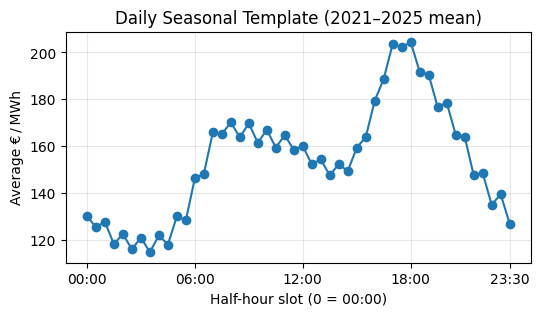

In [163]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 4: Build a 48-point daily seasonal template from df_price_hist
# ────────────────────────────────────────────────────────────────────────────────

# (1) Reset index so Timestamp is a column
df_temp = df_price_hist.reset_index().rename(columns={"index": "Timestamp", "Price_EUR": "Price"})

# (2) Extract “time of day” (HH:MM:SS) for each row
df_temp["TimeOfDay"] = df_temp["Timestamp"].dt.strftime("%H:%M:%S")

# (3) Group by TimeOfDay and average Price across all days (2021–2025)
daily_template = (
    df_temp.groupby("TimeOfDay")["Price"]
           .mean()
           .sort_index()    # ensures "00:00:00" → "23:30:00" in order
)

# (4) Convert that into a NumPy array of length 48
seasonal_template = daily_template.values
assert len(seasonal_template) == 48, "Expected 48 half-hour slots’ mean."

# (5) Quick sanity‐plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.plot(range(48), seasonal_template, marker="o")
plt.xticks([0, 12, 24, 36, 47], ["00:00","06:00","12:00","18:00","23:30"])
plt.xlabel("Half-hour slot (0 = 00:00)")
plt.ylabel("Average € / MWh")
plt.title("Daily Seasonal Template (2021–2025 mean)")
plt.grid(True, alpha=0.3)
plt.show()

In [164]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 5A (install ARCH, then do STL + ARIMA + GARCH on 2021–2025 residuals)
# ────────────────────────────────────────────────────────────────────────────────

# 0) Install the ARCH library
!pip install arch

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from statsmodels.tsa.seasonal import STL

# (1) Run STL with period=48 on the five-year Price_EUR series
stl_full = STL(df_price_hist["Price_EUR"], period=48, robust=True)
res_full = stl_full.fit()

seasonal_full = res_full.seasonal.values   # length = 5 × 365/366 × 48
trend_full    = res_full.trend.values      # same
resid_full    = res_full.resid.values      # same

print("➜ Seasonal/trend/resid lengths:", len(seasonal_full), len(trend_full), len(resid_full))

# (2) Fit an ARIMA(1,0,1) on resid_full
import statsmodels.api as sm
arima_mod_full = sm.tsa.SARIMAX(resid_full, order=(1,0,1), enforce_stationarity=False, enforce_invertibility=False)
arima_full_res = arima_mod_full.fit(disp=False)
print("ARIMA fitted on 2021–2025 residuals → AIC:", arima_full_res.aic)

# (3) Fit a GARCH(1,1) on the same residuals
from arch import arch_model
garch_mod_full = arch_model(resid_full, mean="Zero", vol="GARCH", p=1, q=1)
garch_full_res  = garch_mod_full.fit(disp="off")
print("GARCH(1,1) fitted on 2021–2025 residuals → AIC:", garch_full_res.aic)

# (4) Build “seasonal_one_year”: pick any single calendar year’s 48-slot template from seasonal_full
#     (We want an array of length 17 520 per non‐leap year; simplest is take 2021’s slice, drop Feb 29 if present)
#     First, create a full-length “date index” for 2021 (non-leap), 17 520 points:
year = 2021
idx_2021 = pd.date_range(start=f"{year}-01-01 00:00", end=f"{year}-12-31 23:30", freq="30T", tz="UTC")
#    But 2021 is not leap, so idx_2021 has len=365×48=17 520. Now map every timestamp to “time of day” and pull from daily_template:
df_2021 = pd.DataFrame({"Timestamp": idx_2021})
df_2021["TimeOfDay"] = df_2021["Timestamp"].dt.strftime("%H:%M:%S")
seasonal_one_year = df_2021["TimeOfDay"].map(daily_template).values
assert len(seasonal_one_year) == 17_520, "Need 17 520 seasonal slots for one non-leap year."

➜ Seasonal/trend/resid lengths: 87648 87648 87648
ARIMA fitted on 2021–2025 residuals → AIC: 757297.3994389763
GARCH(1,1) fitted on 2021–2025 residuals → AIC: 570935.3721807761


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipython-input-164-1440893294.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  idx_2021 = pd.date_range(start=f"{year}-01-01 00:00", end=f"{year}-12-31 23:30", freq="30T", tz="UTC")


In [165]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 6A (Leap-year–aware; always produces 17 520 points per year)
# ────────────────────────────────────────────────────────────────────────────────

def generate_price_year_from_full_model(
    year_idx,
    base_year=2025,
    arima_res=arima_full_res,
    garch_res=garch_full_res,
    seasonal_one_year=seasonal_one_year,
    drift_rate=0.005,
    cap_price=500.0
):
    """
    Builds a synthetic price series for one future calendar year (n = 17 520 half-hours),
    by combining:
      • a 17 520-length “seasonal” template (from 2021–2025 average),
      • an ARIMA(1,1,1) residual simulation of length 17 520,
      • a GARCH(1,1) shock simulation of length 17 520 (with fallback if α+β ≥ 1),
      • a small drift term that compounds to (1+drift_rate) over that year,
      • then capping at cap_price.
    """

    # 1) Determine the calendar year we want (e.g. if base_year=2025, year_idx=0 → 2026)
    year = base_year + 1 + year_idx

    # 2) Build a full 30 min index from Jan 1 → Dec 31 (leap years have 366*48 = 17 568)
    full_idx = pd.date_range(
        start=f"{year}-01-01 00:00",
        end  =f"{year}-12-31 23:30",
        freq ="30min",
        tz   ="UTC"
    )

    # 3) Drop Feb 29 if it exists (i.e. for leap years). That removes exactly 48 half-hours.
    is_feb29 = (full_idx.month == 2) & (full_idx.day == 29)
    if is_feb29.any():
        full_idx = full_idx[~is_feb29]

    # Now full_idx has length 365*48 = 17 520 for every single year.
    idx = full_idx
    n = len(idx)
    assert n == 365 * 48, f"After dropping Feb 29, expected 17 520 points but got {n}"

    # 4) The 17 520-length seasonal pattern is just the one-year template (length=17 520).
    seasonal_ext = seasonal_one_year.copy()

    # 5) SIMULATE ARIMA residuals of length n:
    try:
        # If statsmodels ≥ 0.14 supports .simulate():
        arima_sims = arima_res.simulate(nsimulations=n)
        arima_sims = np.asarray(arima_sims)
    except AttributeError:
        # Fallback: construct an arma_process with the same ARMA(1,1) params & σ².
        ar_params = arima_res.arima_res_.arparams
        ma_params = arima_res.arima_res_.maparams
        sigma2   = float(arima_res.arima_res_.filter_results.params["sigma2"])
        from statsmodels.tsa.arima_process import ArmaProcess
        arma = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])
        np.random.seed(1000 + year_idx)
        arima_sims = arma.generate_sample(nsample=n, scale=np.sqrt(sigma2))

    # <<< DEBUG PRINTS: ARIMA >>>
    print(f"--- Debug (Year {year} ARIMA) ---")
    print(" ARIMA sim (first 10):", np.round(arima_sims[:10], 4))
    print(" ARIMA range:", np.round(arima_sims.min(),4), "to", np.round(arima_sims.max(),4))

    # 6) SIMULATE GARCH(1,1) shocks of length n:
    params = garch_res.params
    ω = float(params.get("omega",     params.get("omega[0]", np.nan)))
    α = float(params.get("alpha[1]",  params.get("alpha1",  np.nan)))
    β = float(params.get("beta[1]",   params.get("beta1",   np.nan)))

    # 6a) Try computing unconditional var = ω / (1−α−β). If α+β ≥ 1 or var ≤ 0, fallback:
    if (1 - α - β) > 1e-8:
        uncond_var = ω / (1 - α - β)
        use_var = uncond_var if (uncond_var > 0) else None
    else:
        use_var = None

    if use_var is None:
        # Fallback = last in-sample conditional variance from garch_res.conditional_volatility
        try:
            last_vol = float(garch_res.conditional_volatility.iloc[-1])
            use_var = last_vol**2
        except Exception:
            use_var = 1e-6

    σ_uncond = np.sqrt(use_var)
    np.random.seed(2000 + year_idx)
    eps_g = np.random.normal(loc=0.0, scale=1.0, size=n)
    garch_sims = σ_uncond * eps_g

    # <<< DEBUG PRINTS: GARCH >>>
    print(f"--- Debug (Year {year} GARCH) ---")
    print(" α =", round(α, 4), " β =", round(β, 4), " ω =", round(ω, 6))
    print(" Using var =", round(use_var, 6), "→ σ =", round(σ_uncond, 6))
    print(" GARCH sim (first 10):", np.round(garch_sims[:10], 4),
          " range:", np.round(garch_sims.min(),4), "to", np.round(garch_sims.max(),4))

    # 7) BUILD a small drift term that compounds to (1 + drift_rate) over those n half-hours.
    drift_step = (1 + drift_rate) ** (1.0 / n)
    drift_term = np.cumprod(np.full(n, drift_step)) - 1.0

    # <<< DEBUG PRINTS: Drift >>>
    print(f"--- Debug (Year {year} Drift Term) ---")
    print(" Drift (first 10):", np.round(drift_term[:10], 6),
          " range:", round(float(drift_term.min()), 6),
          "to",    round(float(drift_term.max()), 6))

    # 8) COMBINE seasonal + drift + ARIMA + GARCH → raw. Then cap at cap_price:
    raw        = seasonal_ext + drift_term + arima_sims + garch_sims
    raw_capped = np.minimum(raw, cap_price)

    return pd.Series(raw_capped, index=idx)


# ────────────────────────────────────────────────────────────────────────────────
# (After defining generate_price_year_from_full_model, build all 20 years:)
# ────────────────────────────────────────────────────────────────────────────────
years = [generate_price_year_from_full_model(i) for i in range(20)]
df_price_20yr = pd.concat(years)
print("→ Synthetic 20-year price range:", df_price_20yr.min(), "to", df_price_20yr.max())

--- Debug (Year 2026 ARIMA) ---
 ARIMA sim (first 10): [  93.9158 -763.2535 -713.2133 -637.8136 -607.5571 -565.7248 -520.024
 -464.3144 -433.5362 -420.5304]
 ARIMA range: -763.2535 to 145.6965
--- Debug (Year 2026 GARCH) ---
 α = 0.3329  β = 0.6779  ω = 1.1e-05
 Using var = 1e-06 → σ = 0.001
 GARCH sim (first 10): [ 0.0017  0.0019 -0.0021 -0.0001  0.0006 -0.0023  0.0001 -0.0007 -0.0006
 -0.0005]  range: -0.0043 to 0.004
--- Debug (Year 2026 Drift Term) ---
 Drift (first 10): [0.e+00 1.e-06 1.e-06 1.e-06 1.e-06 2.e-06 2.e-06 2.e-06 3.e-06 3.e-06]  range: 0.0 to 0.005
--- Debug (Year 2027 ARIMA) ---
 ARIMA sim (first 10): [ 772.9118 -418.5941 -387.983  -348.7537 -350.0489 -285.7365 -269.4874
 -270.0193 -238.749  -211.4028]
 ARIMA range: -418.5941 to 772.9118
--- Debug (Year 2027 GARCH) ---
 α = 0.3329  β = 0.6779  ω = 1.1e-05
 Using var = 1e-06 → σ = 0.001
 GARCH sim (first 10): [-0.0012  0.0019 -0.0011  0.0008 -0.001  -0.0004 -0.0012  0.0006  0.0006
 -0.0001]  range: -0.0032 to 0.0039
-

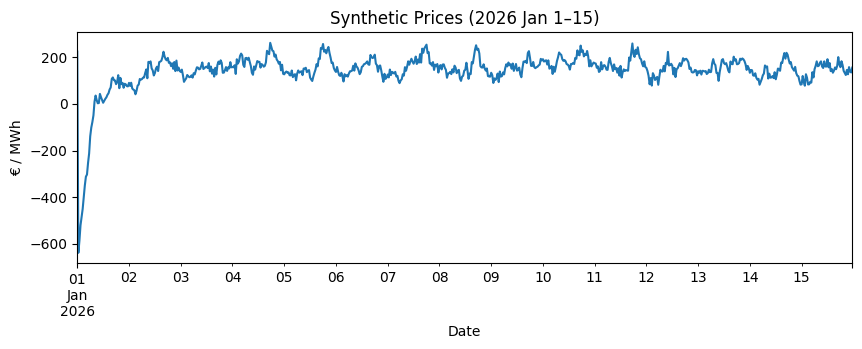

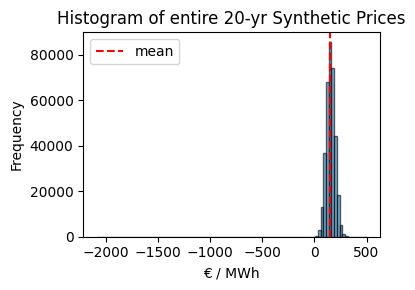

In [166]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 6B: Sanity check plot on the first few months of synthetic series
# ────────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
df_price_20yr["2026-01-01":"2026-01-15"].plot()
plt.title("Synthetic Prices (2026 Jan 1–15)")
plt.ylabel("€ / MWh")
plt.xlabel("Date")
plt.show()

# Show overall distribution
plt.figure(figsize=(4,3))
plt.hist(df_price_20yr.values, bins=100, edgecolor="black", alpha=0.6)
plt.axvline(df_price_20yr.mean(), color="red", linestyle="--", label="mean")
plt.title("Histogram of entire 20-yr Synthetic Prices")
plt.xlabel("€ / MWh")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [167]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 7A (revised): Build 20 years of “PDFB” & “DD-ALL” by tiling 2024 data
# ────────────────────────────────────────────────────────────────────────────────

# (1) Slice out exactly 2024:
df_merged_2024 = df_merged_all.loc["2024-01-01 00:00":"2024-12-31 23:30"].copy()
assert len(df_merged_2024) == 366 * 48, "2024 must be a leap year (17 568 points)."

# (2) Build a full 2024 index (17 568 half-hours), then drop Feb 29:
full_2024_idx = pd.date_range(
    start="2024-01-01 00:00",
    end="2024-12-31 23:30",
    freq="30T",
    tz="UTC"
)
mask_feb29 = (full_2024_idx.month == 2) & (full_2024_idx.day == 29)

# Drop those 48 points from df_merged_2024:
df_2024_nonleap = df_merged_2024.iloc[~mask_feb29].copy()
assert len(df_2024_nonleap) == 17_520

# (3) Extract PDFB and DD-ALL as NumPy arrays (length = 17 520):
pdfb_2024_arr  = df_2024_nonleap["PDFB_Max_Energy_MWh_Interval"].values
ddall_2024_arr = df_2024_nonleap["WF_Charge_Available_MWh_Interval"].values

# (4) For each future year 2026→2045, build a non-leap index of length 17 520:
all_year_idxs = []
for y in range(2026, 2026 + 20):
    full_idx_y = pd.date_range(
        start=f"{y}-01-01 00:00",
        end  =f"{y}-12-31 23:30",
        freq ="30T",
        tz   ="UTC"
    )
    # If it’s a leap year, drop Feb 29:
    mask_feb29_y = (full_idx_y.month == 2) & (full_idx_y.day == 29)
    if mask_feb29_y.any():
        idx_year = full_idx_y[~mask_feb29_y]
    else:
        idx_year = full_idx_y

    assert len(idx_year) == 365 * 48, f"{y} must end up with 17 520 half-hours, got {len(idx_year)}."
    all_year_idxs.append(idx_year)

# (5) Tile the 2024 arrays 20 times (→ length = 20 × 17 520 = 350 400):
pdfb_tile  = np.tile(pdfb_2024_arr, 20)
ddall_tile = np.tile(ddall_2024_arr, 20)

# (6) Concatenate the 20 per-year indices into one big Index (length 350 400):
idx_20yr = all_year_idxs[0].append(all_year_idxs[1:])
assert len(idx_20yr) == 20 * 17_520, f"Expected 350 400 rows, got {len(idx_20yr)}."

# (7) Finally, assemble df_sim_20yr using df_price_20yr from Cell 6A:
df_sim_20yr = pd.DataFrame({
    "Market_Price_EUR_per_MWh":         df_price_20yr.values,
    "PDFB_Max_Energy_MWh_Interval":     pdfb_tile,
    "WF_Charge_Available_MWh_Interval": ddall_tile
}, index=idx_20yr)

print("→ df_sim_20yr built:", df_sim_20yr.shape, "rows.")

→ df_sim_20yr built: (350400, 3) rows.


/tmp/ipython-input-167-2922463543.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_2024_idx = pd.date_range(
/tmp/ipython-input-167-2922463543.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx_y = pd.date_range(


In [168]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 8: Define a helper that applies annual degradation to SoC and then calls run_bess_simulation
# ────────────────────────────────────────────────────────────────────────────────

def run_bess_with_degradation(df_sim_data, cfg, degrad_rate=0.032, bucket_optimize=True):
    """
    Wrapper around run_bess_simulation that applies a yearly capacity fade of `degrad_rate` (e.g. 3.2%/yr)
    to the battery’s usable capacity. We simulate year by year, reducing Usable_Capacity_MWh by degrad_rate
    each January 1st, and carry forward the state‐of‐charge (SoC) between years.

    Inputs:
      • df_sim_data: DataFrame with columns
              ['Market_Price_EUR_per_MWh','PDFB_Max_Energy_MWh_Interval','WF_Charge_Available_MWh_Interval']
        indexed by continuous 20-yr half‐hour timestamps (2026–2045).
      • cfg: a dict with the same keys that run_bess_simulation expects.
      • degrad_rate: fraction of capacity lost per calendar year (default = 0.032 → 3.2%).
      • bucket_optimize: pass‐through to run_bess_simulation.

    Returns:
      • df_all_years: concatenated DataFrame of length 350 400 (20 × 17 520) half-hours, with
          all the same “detailed” columns that run_bess_simulation produces,
          plus a ‘Battery_Year’ column (2026…2045).
      • summary_dict: a dict summarizing each year’s net revenue, cumulative revenue, etc.
    """
    # Make a copy to avoid side‐effects:
    df = df_sim_data.copy()

    # We will build per‐year slices and then concatenate:
    first_year = df.index.year.min()      # e.g. 2026
    last_year  = df.index.year.max()      # e.g. 2045

    yearly_dfs = []
    summary_rows = []

    # Start with initial SoC at cfg['Initial_SoC_MWh']
    current_soc = cfg['Initial_SoC_MWh']

    for year in range(first_year, last_year + 1):
        # 1) Extract exactly that calendar year (17 520 half‐hours):
        start_ts = pd.Timestamp(f"{year}-01-01 00:00", tz="UTC")
        end_ts   = pd.Timestamp(f"{year}-12-31 23:30", tz="UTC")
        df_year  = df.loc[start_ts:end_ts].copy()

        # 2) Adjust the battery’s usable capacity for degradation at the beginning of this year:
        years_elapsed = year - first_year
        # e.g. year=2026 → years_elapsed=0 → no capacity fade; year=2027 → 1 year fade, etc.
        cap_factor = (1.0 - degrad_rate) ** years_elapsed
        local_cfg = cfg.copy()
        local_cfg['Usable_Capacity_MWh'] = cfg['Usable_Capacity_MWh'] * cap_factor

        # 3) Also set that year’s Initial_SoC to the carried‐forward state (capped by new capacity):
        local_cfg['Initial_SoC_MWh'] = min(current_soc, local_cfg['Usable_Capacity_MWh'])

        # 4) Run the normal half‐hour simulation for this single year:
        df_res_year, sum_year = run_bess_simulation(df_year, local_cfg, bucket_optimize=bucket_optimize)

        # 5) After the end of the year, extract final SoC to carry forward:
        current_soc = df_res_year['SoC_MWh'].iloc[-1]

        # 6) Tag this year in both detailed and summary:
        df_res_year['Battery_Year'] = year

        sum_year['Battery_Year'] = year
        sum_year['Usable_Capacity_MWh_Start'] = local_cfg['Usable_Capacity_MWh']
        sum_year['Final_SoC_MWh'] = current_soc

        yearly_dfs.append(df_res_year)
        summary_rows.append(sum_year)

    # 7) Concatenate all 20 years:
    df_all_years = pd.concat(yearly_dfs)
    df_summary  = pd.DataFrame(summary_rows)

    # 8) Build a consolidated summary (e.g. total revenue over 20 yrs, etc.)
    total_revenue = df_summary['Total_Revenue_EUR'].sum()
    total_cost    = df_summary['Total_Operational_Cost_EUR'].sum()
    total_deg     = df_summary['Total_Degradation_Cost_EUR'].sum()
    net_20yr      = total_revenue - total_cost - total_deg

    consolidated = {
        'Total_Revenue_20yr_EUR':           total_revenue,
        'Total_Operational_Cost_20yr_EUR':  total_cost,
        'Total_Degradation_Cost_20yr_EUR':  total_deg,
        'Net_Profit_20yr_EUR':              net_20yr
    }

    return df_all_years, df_summary, consolidated

In [169]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 8A: Specify one or more BESS configurations to test over 20 years
# ────────────────────────────────────────────────────────────────────────────────

# Example: 50 MW / 4 h battery (200 MWh) with the same parameters as 2024 notebook:
bess_50mw_4h = {
    'name': 'BESS_50MW_4h',
    'Initial_SoC_MWh':                          160.0,    # 80% of 200 MWh
    'Usable_Capacity_MWh':                      200.0,
    'Max_Charge_Discharge_Energy_per_Interval': 25.0,     # 50 MW → 25 MWh in 0.5 h
    'One_Way_Efficiency':                       0.95,
    'WF_Constraint_Charge_SoC_Threshold_Mwh':   150.0,
    'WF_Charge_Cost_EUR_per_MWh':               101.42,
    'Fixed_Discharge_Trigger_Price_EUR_per_MWh': 85.0,
    'Fixed_Grid_Charge_Trigger_Price_EUR_per_MWh': 40.0,
    'Use_Dynamic_Triggers':                     True,
    'Dynamic_Trigger_Window_Hours':             24,
    'Charge_Price_Quantile':                    0.30,
    'Discharge_Price_Quantile':                 0.75,
    'Min_Dynamic_Discharge_Price':              60.0,
    'Max_Dynamic_Charge_Price':                 70.0,
    'Degradation_Cost_EUR_per_MWh_cycled':       3.0,
    'Lookahead_Window_Hours':                   6,
    'Min_Grid_Arbitrage_Spread_EUR_per_MWh':     8.0,
    'Interval_Duration_Hours':                   0.5
}

# Recompute derived entries for each scenario:
for cfg in [bess_50mw_4h]:
    cfg['Rolling_Window_Intervals'] = int(cfg['Dynamic_Trigger_Window_Hours'] / cfg['Interval_Duration_Hours'])
    cfg['Lookahead_Intervals']      = int(cfg['Lookahead_Window_Hours'] / cfg['Interval_Duration_Hours'])
    cfg['Round_Trip_Efficiency']    = cfg['One_Way_Efficiency'] ** 2

battery_list = [bess_50mw_4h]

In [170]:
# ────────────────────────────────────────────────────────────────────────────────
# [Re-insert] Cell: run_bess_simulation (patched to respect CRM reserve)
# ────────────────────────────────────────────────────────────────────────────────

def run_bess_simulation(df_sim_data, cfg, bucket_optimize=True):
    import numpy as np
    import pandas as pd

    # 1) Compute rolling quantiles + future max
    df_sim_data['Market_Price_EUR_per_MWh'] = pd.to_numeric(
        df_sim_data['Market_Price_EUR_per_MWh'], errors='coerce'
    ).fillna(0)

    df_sim_data['Rolling_Lower_Quantile_Price'] = (
        df_sim_data['Market_Price_EUR_per_MWh']
        .rolling(window=cfg['Rolling_Window_Intervals'], min_periods=1)
        .quantile(cfg['Charge_Price_Quantile'])
        .ffill().bfill()
    )
    df_sim_data['Rolling_Upper_Quantile_Price'] = (
        df_sim_data['Market_Price_EUR_per_MWh']
        .rolling(window=cfg['Rolling_Window_Intervals'], min_periods=1)
        .quantile(cfg['Discharge_Price_Quantile'])
        .ffill().bfill()
    )
    df_sim_data['Future_Max_Price'] = (
        df_sim_data['Market_Price_EUR_per_MWh']
        .shift(-cfg['Lookahead_Intervals'])
        .rolling(window=cfg['Lookahead_Intervals'], min_periods=1)
        .max()
        .fillna(0)
    )

    # 2) Initialize SoC, counters, etc.
    current_soc_mwh = np.clip(cfg['Initial_SoC_MWh'], 0, cfg['Usable_Capacity_MWh'])
    results = []
    total_revenue = total_cost = total_degradation_cost_eur = 0.0
    missed_ops = {'discharge': 0, 'charge': 0}

    # 3) Precompute forced‐charge/discharge slots if bucket_optimize=True
    if bucket_optimize:
        df_sim_data['Date'] = df_sim_data.index.date
        force_charge_idxs = set()
        force_discharge_idxs = set()
        N = int(cfg['Usable_Capacity_MWh'] / cfg['Max_Charge_Discharge_Energy_per_Interval'])
        for _, grp in df_sim_data.groupby('Date'):
            p = grp['Market_Price_EUR_per_MWh']
            force_charge_idxs.update(p.nsmallest(N).index)
            force_discharge_idxs.update(p.nlargest(N).index)
    else:
        force_charge_idxs = force_discharge_idxs = set()

    # 4) Main loop over every half-hour
    for timestamp, row in df_sim_data.iterrows():
        price               = row['Market_Price_EUR_per_MWh']
        pdfb_allowance      = row['PDFB_Max_Energy_MWh_Interval']
        wf_available_charge = row['WF_Charge_Available_MWh_Interval']
        reserved            = row.get('Reserved_CRM_MW', 0.0)
        month               = timestamp.month

        # seasonal override for May
        if month == 5:
            discharge_trigger = 110.0
            charge_trigger    = 95.0
            min_spread        = 5.0
        else:
            discharge_trigger = max(cfg['Min_Dynamic_Discharge_Price'], row['Rolling_Upper_Quantile_Price'])
            charge_trigger    = min(cfg['Max_Dynamic_Charge_Price'], row['Rolling_Lower_Quantile_Price'])
            min_spread        = cfg['Min_Grid_Arbitrage_Spread_EUR_per_MWh']

        is_fc = timestamp in force_charge_idxs
        is_fd = timestamp in force_discharge_idxs

        action                    = "Idle"
        echg_gross                = 0.0
        edis_net                  = 0.0
        irev                      = 0.0
        icost                     = 0.0
        ideg_cost                 = 0.0
        cost_grid = cost_wind    = 0.0

        # — A) FORCED DISCHARGE (must respect reserve) —
        if is_fd and current_soc_mwh > reserved + 1e-6 and pdfb_allowance > 1e-6:
            avail = current_soc_mwh - reserved
            net_possible = min(pdfb_allowance,
                                cfg['Max_Charge_Discharge_Energy_per_Interval'],
                                avail * cfg['One_Way_Efficiency'])
            if net_possible > 0:
                edis_net = net_possible
                current_soc_mwh -= net_possible / cfg['One_Way_Efficiency']
                irev = net_possible * price
                ideg_cost = net_possible * cfg['Degradation_Cost_EUR_per_MWh_cycled']
                action = f"Force Discharge ({net_possible:.2f} MWh @ {price:.2f})"

        # — B) FORCED CHARGE —
        elif is_fc and current_soc_mwh < cfg['Usable_Capacity_MWh'] - 1e-6:
            gap = cfg['Usable_Capacity_MWh'] - current_soc_mwh
            gross_possible = min(cfg['Max_Charge_Discharge_Energy_per_Interval'],
                                 gap / cfg['One_Way_Efficiency'])
            if gross_possible > 0:
                if wf_available_charge > 1e-6 and current_soc_mwh < cfg['WF_Constraint_Charge_SoC_Threshold_Mwh']:
                    actual = min(wf_available_charge, gross_possible)
                    current_soc_mwh += actual * cfg['One_Way_Efficiency']
                    cost_wind = actual * price
                    icost = cost_wind
                    echg_gross = actual
                    action = f"Force Charge Wind ({actual:.2f} MWh @ {price:.2f})"
                else:
                    actual = gross_possible
                    current_soc_mwh += actual * cfg['One_Way_Efficiency']
                    cost_grid = actual * price
                    icost = cost_grid
                    echg_gross = actual
                    action = f"Force Charge Grid ({actual:.2f} MWh @ {price:.2f})"

        # — C) NORMAL DYNAMIC / FALLBACK LOGIC —
        else:
            # C.1) DISCHARGE …
            if pdfb_allowance > 1e-6 and current_soc_mwh > reserved + 1e-6:
                avail = current_soc_mwh - reserved
                net_possible = min(pdfb_allowance,
                                   cfg['Max_Charge_Discharge_Energy_per_Interval'],
                                   avail * cfg['One_Way_Efficiency'])
                if price > discharge_trigger and net_possible > 1e-6:
                    edis_net = net_possible
                    current_soc_mwh -= net_possible / cfg['One_Way_Efficiency']
                    irev = net_possible * price
                    ideg_cost = net_possible * cfg['Degradation_Cost_EUR_per_MWh_cycled']
                    action = f"Discharge ({net_possible:.2f} MWh @ {price:.2f})"
                elif price > cfg['Fixed_Discharge_Trigger_Price_EUR_per_MWh']:
                    missed_ops['discharge'] += 1

            # C.2) CHARGE …
            elif current_soc_mwh < cfg['Usable_Capacity_MWh'] - 1e-6:
                gap = cfg['Usable_Capacity_MWh'] - current_soc_mwh
                gross_possible = min(cfg['Max_Charge_Discharge_Energy_per_Interval'],
                                     gap / cfg['One_Way_Efficiency'])
                if gross_possible > 1e-6:
                    if wf_available_charge > 1e-6 and current_soc_mwh < cfg['WF_Constraint_Charge_SoC_Threshold_Mwh']:
                        actual = min(wf_available_charge, gross_possible)
                        current_soc_mwh += actual * cfg['One_Way_Efficiency']
                        cost_wind = actual * price
                        icost = cost_wind
                        echg_gross = actual
                        action = f"Charge Wind ({actual:.2f} MWh @ {price:.2f})"
                    else:
                        future = row['Future_Max_Price']
                        net_from_cycle = gross_possible * cfg['Round_Trip_Efficiency']
                        profit_est = (net_from_cycle * future
                                      - gross_possible * price
                                      - net_from_cycle * cfg['Degradation_Cost_EUR_per_MWh_cycled'])
                        if (price < charge_trigger and future > price
                            and profit_est > min_spread * gross_possible):
                            actual = gross_possible
                            current_soc_mwh += actual * cfg['One_Way_Efficiency']
                            cost_grid = actual * price
                            icost = cost_grid
                            echg_gross = actual
                            action = f"Charge Grid ({actual:.2f} MWh @ {price:.2f})"
                        else:
                            missed_ops['charge'] += 1

        # D) update running totals & record row
        total_revenue          += irev
        total_cost             += (cost_grid + cost_wind)
        total_degradation_cost_eur += ideg_cost
        current_soc_mwh         = np.clip(current_soc_mwh, 0, cfg['Usable_Capacity_MWh'])

        results.append({
            'Timestamp': timestamp,
            'SoC_MWh': current_soc_mwh,
            'Reserved_CRM_MW': reserved,
            'Market_Price_EUR_per_MWh': price,
            'Action': action,
            'Energy_Discharged_Net_MWh': edis_net,
            'Energy_Charged_Gross_MWh': echg_gross,
            'Revenue_EUR': irev,
            'Operational_Cost_EUR': (cost_grid + cost_wind),
            'Cost_Grid_EUR': cost_grid,
            'Cost_Wind_EUR': cost_wind,
            'Degradation_Cost_EUR': ideg_cost,
            'Dynamic_Discharge_Trigger': discharge_trigger if cfg['Use_Dynamic_Triggers'] else np.nan,
            'Dynamic_Charge_Trigger': charge_trigger    if cfg['Use_Dynamic_Triggers'] else np.nan,
            'Future_Max_Price': row['Future_Max_Price'],
            'Rolling_Lower_Quantile_Price': row['Rolling_Lower_Quantile_Price'],
            'Rolling_Upper_Quantile_Price': row['Rolling_Upper_Quantile_Price'],
            'PDFB_Max_Energy_MWh_Interval': pdfb_allowance,
            'WF_Charge_Available_MWh_Interval': wf_available_charge,
        })

    df_result = pd.DataFrame(results).set_index('Timestamp')
    summary = {
        'Total_Revenue_EUR':           total_revenue,
        'Total_Operational_Cost_EUR':  total_cost,
        'Total_Degradation_Cost_EUR':  total_degradation_cost_eur,
        'Net_Profit_EUR':              total_revenue - total_cost - total_degradation_cost_eur,
        'Total_Energy_Discharged_Net_MWh': df_result['Energy_Discharged_Net_MWh'].sum(),
        'Total_Energy_Charged_Gross_MWh':  df_result['Energy_Charged_Gross_MWh'].sum(),
        'Missed_Discharge_Ops':         missed_ops['discharge'],
        'Missed_Charge_Ops':            missed_ops['charge']
    }
    return df_result, summary

In [171]:
def run_bess_with_degradation(df_sim_data, cfg, degrad_rate=0.032, bucket_optimize=True):
    """
    Runs a multi‐year BESS simulation by splitting df_sim_data into 1‐year chunks,
    carrying forward state‐of‐charge and degrading usable capacity each year.

    Returns:
      • df_result_all: concatenated half‐hour results for all years
      • df_yearly:     one‐row summary per year
      • total_summary: final dictionary with 20‐year totals + final capacity/SoC
    """
    # Make a copy of cfg so we can tweak it each iteration
    local_cfg = cfg.copy()
    results_full = []
    summary_rows  = []

    # Starting conditions from cfg
    current_initial_soc  = cfg['Initial_SoC_MWh']
    current_capacity_mwh = cfg['Usable_Capacity_MWh']

    # Loop over each calendar year present in df_sim_data
    for year in sorted(df_sim_data.index.year.unique()):
        # ─────────────────────────────────────────────────────────────────────────
        # 1) Extract that calendar year's worth of half‐hour data:
        #    Note: both endpoints must be f‐strings so they interpolate correctly.
        df_year = df_sim_data.loc[f"{year}-01-01": f"{year}-12-31"].copy()
        # ─────────────────────────────────────────────────────────────────────────

        # ─────────────────────────────────────────────────────────────────────────
        # 2) Update local_cfg for this year's starting SoC/capacity
        local_cfg['Usable_Capacity_MWh'] = current_capacity_mwh
        local_cfg['Initial_SoC_MWh']     = current_initial_soc
        # (If you want power rating to degrade in proportion to capacity, adjust
        #  local_cfg['Max_Charge_Discharge_Energy_per_Interval'] here as well—
        #  otherwise leave it unchanged.)
        # ─────────────────────────────────────────────────────────────────────────

        # ─────────────────────────────────────────────────────────────────────────
        # 3) Run standard half‐hour simulation for this single year
        df_res_year, sum_year = run_bess_simulation(
            df_year,
            local_cfg,
            bucket_optimize=bucket_optimize
        )
        df_res_year['Year'] = year
        results_full.append(df_res_year)
        # ─────────────────────────────────────────────────────────────────────────

        # ─────────────────────────────────────────────────────────────────────────
        # 4) Build that year's summary row and store it
        sum_year['Year'] = year
        sum_year['Capacity_Start_MWh'] = current_capacity_mwh
        summary_rows.append(sum_year)
        # ─────────────────────────────────────────────────────────────────────────

        # ─────────────────────────────────────────────────────────────────────────
        # 5) Carry forward final SoC and degrade capacity for the next year
        end_soc = df_res_year['SoC_MWh'].iloc[-1]
        current_initial_soc = end_soc
        current_capacity_mwh *= (1 - degrad_rate)
        # ─────────────────────────────────────────────────────────────────────────

    # ────────────────────────────────────────────────────────────────────────────────
    # 6) Concatenate per‐year results & per‐year summaries
    df_result_all = pd.concat(results_full)
    df_yearly     = pd.DataFrame(summary_rows)

    # 7) Build a consolidated 20‐year summary
    total_summary = {
        'Total_Revenue_EUR':          df_yearly['Total_Revenue_EUR'].sum(),
        'Total_Operational_Cost_EUR': df_yearly['Total_Operational_Cost_EUR'].sum(),
        'Total_Degradation_Cost_EUR': df_yearly['Total_Degradation_Cost_EUR'].sum(),
        'Net_Profit_EUR':             df_yearly['Net_Profit_EUR'].sum(),
        'Final_Capacity_MWh':         current_capacity_mwh,
        'Final_End_SoC_MWh':          current_initial_soc
    }
    # ────────────────────────────────────────────────────────────────────────────────

    return df_result_all, df_yearly, total_summary

In [172]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell Y: Build the four battery configs and battery_list
# ────────────────────────────────────────────────────────────────────────────────

# (1) 50 MW × 4 h is your “base” config from earlier:
config_50MW_4h = config.copy()

# (2) 50 MW × 2 h → 100 MWh total, 80 % SoC → 80 MWh, same power rating (25 MWh/interval)
config_50MW_2h = config.copy()
config_50MW_2h['Usable_Capacity_MWh'] = 50.0 * 2       # 100 MWh
config_50MW_2h['Initial_SoC_MWh']     = 0.80 * 100.0   # 80 MWh

# (3) 100 MW × 4 h → 400 MWh total, 80 % SoC → 320 MWh, 50 MWh/interval
config_100MW_4h = config.copy()
config_100MW_4h['Usable_Capacity_MWh']                     = 100.0 * 4    # 400 MWh
config_100MW_4h['Initial_SoC_MWh']                         = 0.80 * 400.0 # 320 MWh
config_100MW_4h['Max_Charge_Discharge_Energy_per_Interval'] = 100.0 * 0.5  # 50 MWh

# (4) 100 MW × 2 h → 200 MWh total, 80 % SoC → 160 MWh, 50 MWh/interval
config_100MW_2h = config.copy()
config_100MW_2h['Usable_Capacity_MWh']                     = 100.0 * 2    # 200 MWh
config_100MW_2h['Initial_SoC_MWh']                         = 0.80 * 200.0 # 160 MWh
config_100MW_2h['Max_Charge_Discharge_Energy_per_Interval'] = 100.0 * 0.5  # 50 MWh

# (5) Recompute any derived fields (rolling/lookahead windows, round-trip) if needed
for cfg in (config_50MW_4h, config_50MW_2h, config_100MW_4h, config_100MW_2h):
    cfg['Rolling_Window_Intervals'] = int(cfg['Dynamic_Trigger_Window_Hours'] / cfg['Interval_Duration_Hours'])
    cfg['Lookahead_Intervals']      = int(cfg['Lookahead_Window_Hours']  / cfg['Interval_Duration_Hours'])
    cfg['Round_Trip_Efficiency']    = cfg['One_Way_Efficiency'] ** 2

# (6) Finally, assemble battery_list for the 4 scenarios:
battery_list = [
    { "name": "50MW_4h",  **config_50MW_4h },
    { "name": "50MW_2h",  **config_50MW_2h },
    { "name": "100MW_4h", **config_100MW_4h },
    { "name": "100MW_2h", **config_100MW_2h },
]


In [173]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 8B (revised): Loop over each battery config, run the 20-yr sim, save outputs
# ────────────────────────────────────────────────────────────────────────────────

# (A) Annual degradation rate
degrad_rate = 0.032   # 3.2%/year

# (B) Prepare a place to store “in-memory” DataFrames if you want later
detailed_outputs = {}
yearly_outputs   = {}
summary_rows     = []

# (C) battery_list must already be defined (it contains dicts with name + config)
#    For example:
#    battery_list = [
#       {'name':'50MW_4h',  **config_50MW_4h},
#       {'name':'50MW_2h',  **config_50MW_2h},
#       {'name':'100MW_4h', **config_100MW_4h},
#       {'name':'100MW_2h', **config_100MW_2h},
#    ]

for bess in battery_list:
    name = bess['name']
    print(f"\n--- Simulating {name} over 2026–2045 (20 yrs) with {degrad_rate*100:.1f}%/yr degradation ---")

    # (1) Run the 20-year simulation (this returns three things)
    df_detailed, df_yearly, consolidated = run_bess_with_degradation(
        df_sim_20yr,
        bess,
        degrad_rate=degrad_rate,
        bucket_optimize=True
    )

    # (2) Write out the half-hour “detailed” file to disk
    detailed_fname = f"bess_{name}_20yr_detailed.csv"
    df_detailed.to_csv(detailed_fname)
    print(f"  • Saved 20-yr detailed intervals to: {detailed_fname}")

    # (3) Also write out the per-year summary that run_bess_with_degradation returned
    yearly_fname = f"bess_{name}_yearly_summary_20yr.csv"
    df_yearly.to_csv(yearly_fname, index=False)
    print(f"  • Saved per-year summary to: {yearly_fname}")

    # (4) Keep them in memory, if you want to inspect later
    detailed_outputs[name] = df_detailed
    yearly_outputs[name]   = df_yearly

    # (5) Record the consolidated (single-row) 20-yr summary
    consolidated.update({'BESS_Name': name})
    summary_rows.append(consolidated)

# (D) Build & save the final “consolidated” 20-year summary (one row per battery)
df_20yr_consolidated = pd.DataFrame(summary_rows).set_index('BESS_Name')
df_20yr_consolidated.to_csv("bess_20yr_consolidated_summary.csv")
print("\n=== 20-Year Consolidated Results (one row per battery) ===")
print(df_20yr_consolidated)
print("\n✅ All detailed + yearly CSVs are now written!")


--- Simulating 50MW_4h over 2026–2045 (20 yrs) with 3.2%/yr degradation ---
  • Saved 20-yr detailed intervals to: bess_50MW_4h_20yr_detailed.csv
  • Saved per-year summary to: bess_50MW_4h_yearly_summary_20yr.csv

--- Simulating 50MW_2h over 2026–2045 (20 yrs) with 3.2%/yr degradation ---
  • Saved 20-yr detailed intervals to: bess_50MW_2h_20yr_detailed.csv
  • Saved per-year summary to: bess_50MW_2h_yearly_summary_20yr.csv

--- Simulating 100MW_4h over 2026–2045 (20 yrs) with 3.2%/yr degradation ---
  • Saved 20-yr detailed intervals to: bess_100MW_4h_20yr_detailed.csv
  • Saved per-year summary to: bess_100MW_4h_yearly_summary_20yr.csv

--- Simulating 100MW_2h over 2026–2045 (20 yrs) with 3.2%/yr degradation ---
  • Saved 20-yr detailed intervals to: bess_100MW_2h_20yr_detailed.csv
  • Saved per-year summary to: bess_100MW_2h_yearly_summary_20yr.csv

=== 20-Year Consolidated Results (one row per battery) ===
           Total_Revenue_EUR  Total_Operational_Cost_EUR  \
BESS_Name     

In [174]:
import pandas as pd
import numpy as np
import os

# ────────────────────────────────────────────────────────────────────────────────
# STEP 1: Define which scenarios you have detailed CSVs for
# ────────────────────────────────────────────────────────────────────────────────

scenarios = [
    "50MW_4h",
    "50MW_2h",
    "100MW_4h",
    "100MW_2h",
]

# For each scenario, we expect to find a file named:
#    bess_<SCENARIO>_20yr_detailed.csv
# in the current working directory. If you’ve stored them
# somewhere else, adjust the paths below accordingly.

# ────────────────────────────────────────────────────────────────────────────────
# STEP 2: Loop over each scenario, load the detailed CSV, and compute per-year aggregates
# ────────────────────────────────────────────────────────────────────────────────

for name in scenarios:
    detailed_fname = f"bess_{name}_20yr_detailed.csv"

    if not os.path.exists(detailed_fname):
        raise FileNotFoundError(f"Could not find '{detailed_fname}'. Make sure the file exists in the working directory.")

    # 2.A) Read the detailed half-hour DataFrame
    df = pd.read_csv(detailed_fname, parse_dates=["Timestamp"], index_col="Timestamp")
    # At this point, 'df' should have at least these columns:
    #    - Market_Price_EUR_per_MWh
    #    - Energy_Discharged_Net_MWh
    #    - Energy_Charged_Gross_MWh
    #    - Cost_Grid_EUR
    #    - Cost_Wind_EUR
    #    - Degradation_Cost_EUR
    #    - SoC_MWh
    #    - PDFB_Max_Energy_MWh_Interval
    #    - WF_Charge_Available_MWh_Interval
    #
    # If your column names differ, adjust the names below.

    # 2.B) Tag each row by calendar year
    df["Year"] = df.index.year

    # 2.C) Split “Energy_Charged_Gross_MWh” into grid vs wind buckets
    df["Energy_Charged_Wind_MWh"] = np.where(
        df["Cost_Wind_EUR"] > 0,
        df["Energy_Charged_Gross_MWh"],
        0.0
    )
    df["Energy_Charged_Grid_MWh"] = np.where(
        df["Cost_Grid_EUR"] > 0,
        df["Energy_Charged_Gross_MWh"],
        0.0
    )

    # ────────────────────────────────────────────────────────────────────────────────
    # STEP 3: Aggregate by Year
    # ────────────────────────────────────────────────────────────────────────────────
    yearly = df.groupby("Year").agg(
        # (1) Average market price over all half-hours in that year
        Avg_Market_Price_EUR_per_MWh      = ("Market_Price_EUR_per_MWh", "mean"),

        # (2) Total energy sold to grid ("discharged") over half-hours in that year
        Total_Energy_Discharged_MWh       = ("Energy_Discharged_Net_MWh", "sum"),

        # (3) Total energy charged (gross) in that year
        Total_Energy_Charged_MWh          = ("Energy_Charged_Gross_MWh", "sum"),

        # (4) Energy charged from grid vs wind
        Energy_Charged_Grid_MWh           = ("Energy_Charged_Grid_MWh", "sum"),
        Energy_Charged_Wind_MWh           = ("Energy_Charged_Wind_MWh", "sum"),

        # (5) Cost of charging from grid vs wind
        Cost_Charging_Grid_EUR            = ("Cost_Grid_EUR", "sum"),
        Cost_Charging_Wind_EUR            = ("Cost_Wind_EUR", "sum"),

        # (6) Total degradation cost for that year
        Total_Degradation_Cost_EUR        = ("Degradation_Cost_EUR", "sum"),

        # (7) Gross revenue from all discharges in that year
        Gross_Revenue_EUR                 = ("Revenue_EUR", "sum"),

        # (8) Max State-of-Charge reached in any half-hour that year
        Max_SoC_MWh                       = ("SoC_MWh", "max"),

        # (9) Sum of PDFB (export availability) over all half-hours that year
        Sum_PDFB_MWh                      = ("PDFB_Max_Energy_MWh_Interval", "sum"),

        # (10) Sum of wind-farm charge availability (“DD ALL”) over all half-hours
        Sum_WF_Charge_Available_MWh       = ("WF_Charge_Available_MWh_Interval", "sum"),
    ).reset_index()

    # 3.A) Compute Net revenue = Gross_Revenue – (grid cost + wind cost + degradation cost)
    yearly["Net_Revenue_EUR"] = (
          yearly["Gross_Revenue_EUR"]
        - yearly["Cost_Charging_Grid_EUR"]
        - yearly["Cost_Charging_Wind_EUR"]
        - yearly["Total_Degradation_Cost_EUR"]
    )

    # 3.B) Re‐order columns if you want exactly this ordering:
    desired_order = [
        "Year",
        "Avg_Market_Price_EUR_per_MWh",
        "Total_Energy_Discharged_MWh",
        "Total_Energy_Charged_MWh",
        "Energy_Charged_Grid_MWh",
        "Energy_Charged_Wind_MWh",
        "Cost_Charging_Grid_EUR",
        "Cost_Charging_Wind_EUR",
        "Total_Degradation_Cost_EUR",
        "Gross_Revenue_EUR",
        "Net_Revenue_EUR",
        "Max_SoC_MWh",
        "Sum_PDFB_MWh",
        "Sum_WF_Charge_Available_MWh",
    ]
    missing_cols = [c for c in desired_order if c not in yearly.columns]
    if missing_cols:
        raise KeyError(
            f"In scenario '{name}', the following requested columns are missing from the aggregated DataFrame: {missing_cols}"
        )

    yearly = yearly[desired_order]

    # ────────────────────────────────────────────────────────────────────────────────
    # STEP 4: Save out this “custom per-year” CSV
    # ────────────────────────────────────────────────────────────────────────────────
    out_fn = f"custom_yearly_summary_{name}.csv"
    yearly.to_csv(out_fn, index=False)
    print(f"→ Wrote custom per-year CSV for {name}: {out_fn}")

# ────────────────────────────────────────────────────────────────────────────────
# If you also want to combine all four scenarios into one large table (with a “Scenario” column),
# simply do:
# ────────────────────────────────────────────────────────────────────────────────

# Re-load each “custom_yearly_summary_<scenario>.csv” and add a “Scenario” column,
# then concatenate them all:
all_dfs = []
for name in scenarios:
    fn = f"custom_yearly_summary_{name}.csv"
    if not os.path.exists(fn):
        raise FileNotFoundError(f"Expected to find '{fn}', but it does not exist.")
    temp = pd.read_csv(fn)
    temp["Scenario"] = name
    all_dfs.append(temp)

all_yearly = pd.concat(all_dfs, ignore_index=True)

# And if you’d like, save that combined table too:
all_yearly.to_csv("custom_yearly_summary_all_scenarios.csv", index=False)
print("→ Wrote combined CSV: custom_yearly_summary_all_scenarios.csv")

# Finally, you can inspect it:
print("\n--- Combined first few rows of all scenarios ---")
print(all_yearly.head(10))

→ Wrote custom per-year CSV for 50MW_4h: custom_yearly_summary_50MW_4h.csv
→ Wrote custom per-year CSV for 50MW_2h: custom_yearly_summary_50MW_2h.csv
→ Wrote custom per-year CSV for 100MW_4h: custom_yearly_summary_100MW_4h.csv
→ Wrote custom per-year CSV for 100MW_2h: custom_yearly_summary_100MW_2h.csv
→ Wrote combined CSV: custom_yearly_summary_all_scenarios.csv

--- Combined first few rows of all scenarios ---
   Year  Avg_Market_Price_EUR_per_MWh  Total_Energy_Discharged_MWh  \
0  2026                    154.207749                 46577.767732   
1  2027                    153.629937                 43651.674822   
2  2028                    151.142214                 42741.513455   
3  2029                    152.872485                 42401.475190   
4  2030                    154.355826                 41872.562826   
5  2031                    152.996570                 39225.240490   
6  2032                    152.386827                 38284.158305   
7  2033                 

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
battery_scenarios = [
    ("50MW_4h",  config_50MW_4h),
    ("50MW_2h",  config_50MW_2h),
    ("100MW_4h", config_100MW_4h),
    ("100MW_2h", config_100MW_2h),
]

# Store each scenario’s outputs in a dict, so we can summarize them later
results = {}

for name, cfg in battery_scenarios:
    print(f"\n— Running 20-year sim for {name} —")
    df_detailed, df_yearly, summary = run_bess_with_degradation(
        df_sim_20yr,
        cfg,
        degrad_rate=0.032,
        bucket_optimize=True
    )

    # Save them so we can reference df_detailed later
    results[name] = (df_detailed, df_yearly, summary)

    # Write out that scenario’s yearly CSV
    df_yearly.to_csv(f"bess_yearly_summary_{name}.csv", index=False)

    # Use "Net_Profit_EUR" instead of "Total_Net_Revenue_EUR"
    print(f"{name} → 20-yr Net Revenue = {summary['Net_Profit_EUR']:.2f} €")


— Running 20-year sim for 50MW_4h —
50MW_4h → 20-yr Net Revenue = 35743759.43 €

— Running 20-year sim for 50MW_2h —
50MW_2h → 20-yr Net Revenue = 17345088.63 €

— Running 20-year sim for 100MW_4h —
100MW_4h → 20-yr Net Revenue = 78045534.72 €

— Running 20-year sim for 100MW_2h —
100MW_2h → 20-yr Net Revenue = 35105366.51 €


In [177]:
import pandas as pd
import numpy as np
import os

# ────────────────────────────────────────────────────────────────────────────────
#  Step 0: List all four scenario names (must match how you named your detailed CSVs)
# ────────────────────────────────────────────────────────────────────────────────
scenario_names = [
    "50MW_4h",
    "50MW_2h",
    "100MW_4h",
    "100MW_2h"
]

# ────────────────────────────────────────────────────────────────────────────────
#  Step 1: For each scenario, load its detailed‐interval CSV and compute the per‐year summary
# ────────────────────────────────────────────────────────────────────────────────
for name in scenario_names:
    detailed_fn = f"bess_{name}_20yr_detailed.csv"
    if not os.path.exists(detailed_fn):
        raise FileNotFoundError(
            f"Could not find '{detailed_fn}'. Make sure you ran the 20-yr sim and saved "
            f"the detailed CSV with exactly that filename."
        )

    # Load the half‐hour‐level DataFrame
    df = pd.read_csv(detailed_fn, parse_dates=["Timestamp"], index_col="Timestamp")

    # Tag each row by calendar year
    df["Year"] = df.index.year

    # Step 2: Compute “energy charged by wind” vs. “energy charged by grid”
    #    We know that Cost_Wind_EUR > 0 implies that interval was charged from wind;
    #    Cost_Grid_EUR > 0 implies that interval was charged from grid.
    df["Energy_Charged_Wind_MWh"] = np.where(
        df["Cost_Wind_EUR"] > 0,
        df["Energy_Charged_Gross_MWh"],
        0.0
    )
    df["Energy_Charged_Grid_MWh"] = np.where(
        df["Cost_Grid_EUR"] > 0,
        df["Energy_Charged_Gross_MWh"],
        0.0
    )

    # Step 3: Group by Year and compute all requested metrics
    yearly = df.groupby("Year").agg(
        # —— 1) average market price (over all half‐hour stamps in that year)
        Average_Market_Price_EUR_per_MWh = ("Market_Price_EUR_per_MWh", "mean"),

        # —— 2) total energy discharged (sum of “Energy_Discharged_Net_MWh”)
        Total_Energy_Discharged_MWh      = ("Energy_Discharged_Net_MWh", "sum"),

        # —— 3) total energy charged (gross) = sum of “Energy_Charged_Gross_MWh”
        Total_Energy_Charged_MWh         = ("Energy_Charged_Gross_MWh", "sum"),

        # —— 4) split charging by source:
        Energy_Charged_Grid_MWh          = ("Energy_Charged_Grid_MWh", "sum"),
        Energy_Charged_Wind_MWh          = ("Energy_Charged_Wind_MWh", "sum"),

        # —— 5) charging‐costs (grid vs. wind)
        Energy_Charging_Cost_Grid_EUR     = ("Cost_Grid_EUR", "sum"),
        Energy_Charging_Cost_Wind_EUR     = ("Cost_Wind_EUR", "sum"),

        # —— 6) total degradation cost
        Total_Degradation_Cost_EUR        = ("Degradation_Cost_EUR", "sum"),

        # —— 7) gross revenue (sum of “Revenue_EUR” during all discharge intervals)
        Gross_Revenue_EUR                = ("Revenue_EUR", "sum"),

        # —— 8) net revenue = gross – (grid cost + wind cost + degradation cost)
        #     We’ll compute it just below (after the groupby), because we need
        #     both gross and the various cost sums available in the result first.

        # —— 9) maximum State‐of‐Charge in that year
        Max_SoC_MWh                      = ("SoC_MWh", "max"),

        # —— 10) sum of PDFB (export limit) for the year
        Sum_PDFB_MWh                     = ("PDFB_Max_Energy_MWh_Interval", "sum"),

        # —— 11) sum of WF‐Charge‐Available (on‐site wind energy available)
        Sum_WF_Charge_Available_MWh      = ("WF_Charge_Available_MWh_Interval", "sum"),
    ).reset_index()

    # Step 4: Now that we have Gross_Revenue and all costs, compute Net_Revenue
    yearly["Net_Revenue_EUR"] = (
        yearly["Gross_Revenue_EUR"]
        - yearly["Energy_Charging_Cost_Grid_EUR"]
        - yearly["Energy_Charging_Cost_Wind_EUR"]
        - yearly["Total_Degradation_Cost_EUR"]
    )

    # Step 5: Re‐order columns exactly as you wanted:
    desired_order = [
        "Year",
        "Average_Market_Price_EUR_per_MWh",
        "Total_Energy_Discharged_MWh",
        "Total_Energy_Charged_MWh",
        "Energy_Charged_Grid_MWh",
        "Energy_Charged_Wind_MWh",
        "Energy_Charging_Cost_Grid_EUR",
        "Energy_Charging_Cost_Wind_EUR",
        "Total_Degradation_Cost_EUR",
        "Gross_Revenue_EUR",
        "Net_Revenue_EUR",
        "Max_SoC_MWh",
        "Sum_PDFB_MWh",
        "Sum_WF_Charge_Available_MWh"
    ]

    # If for some reason one of these is missing, raise a helpful KeyError:
    missing_cols = [c for c in desired_order if c not in yearly.columns]
    if missing_cols:
        raise KeyError(
            f"In scenario '{name}', the following required columns were not found in the grouped DataFrame:\n"
            f"   {missing_cols}\n"
            "– Please check that your detailed CSV truly contains all of these half‐hour fields."
        )

    yearly = yearly[desired_order]

    # Step 6: Write out a “custom” CSV for this scenario
    custom_fn = f"bess_yearly_custom_{name}.csv"
    yearly.to_csv(custom_fn, index=False)
    print(f"→ Wrote custom CSV: {custom_fn} (shape = {yearly.shape})")

→ Wrote custom CSV: bess_yearly_custom_50MW_4h.csv (shape = (20, 14))
→ Wrote custom CSV: bess_yearly_custom_50MW_2h.csv (shape = (20, 14))
→ Wrote custom CSV: bess_yearly_custom_100MW_4h.csv (shape = (20, 14))
→ Wrote custom CSV: bess_yearly_custom_100MW_2h.csv (shape = (20, 14))


Columns in 50MW_4h: ['Total_Revenue_EUR', 'Total_Operational_Cost_EUR', 'Total_Degradation_Cost_EUR', 'Net_Profit_EUR', 'Total_Energy_Discharged_Net_MWh', 'Total_Energy_Charged_Gross_MWh', 'Missed_Discharge_Ops', 'Missed_Charge_Ops', 'Year', 'Capacity_Start_MWh']


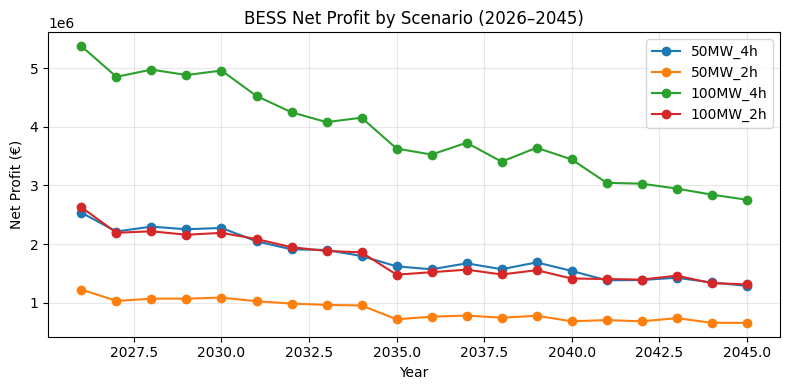

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load each scenario’s yearly‐summary CSV into a dict
scenarios = {
    "50MW_4h":  pd.read_csv("bess_yearly_summary_50MW_4h.csv"),
    "50MW_2h":  pd.read_csv("bess_yearly_summary_50MW_2h.csv"),
    "100MW_4h": pd.read_csv("bess_yearly_summary_100MW_4h.csv"),
    "100MW_2h": pd.read_csv("bess_yearly_summary_100MW_2h.csv"),
}

# 2) (Optional) Inspect the columns to confirm what’s available
print("Columns in 50MW_4h:", scenarios["50MW_4h"].columns.tolist())

# 3) Plot Net_Profit_EUR for each scenario over time
plt.figure(figsize=(8, 4))
for name, df in scenarios.items():
    plt.plot(df["Year"], df["Net_Profit_EUR"], marker="o", label=name)

plt.xlabel("Year")
plt.ylabel("Net Profit (€)")
plt.title("BESS Net Profit by Scenario (2026–2045)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [179]:
import pandas as pd

# 1) Read each scenario’s yearly CSV into these exact variable names:
df_50_4h  = pd.read_csv("bess_yearly_summary_50MW_4h.csv")
df_50_2h  = pd.read_csv("bess_yearly_summary_50MW_2h.csv")
df_100_4h = pd.read_csv("bess_yearly_summary_100MW_4h.csv")
df_100_2h = pd.read_csv("bess_yearly_summary_100MW_2h.csv")

# 2) Tag them with a “Scenario” column using the same variable names:
df_50_4h["Scenario"]  = "50MW_4h"
df_50_2h["Scenario"]  = "50MW_2h"
df_100_4h["Scenario"] = "100MW_4h"
df_100_2h["Scenario"] = "100MW_2h"

# 3) Concatenate into one big DataFrame:
all_yearly = pd.concat(
    [df_50_4h, df_50_2h, df_100_4h, df_100_2h],
    ignore_index=True
)

# 4) Inspect the combined DataFrame:
print(all_yearly.head())

   Total_Revenue_EUR  Total_Operational_Cost_EUR  Total_Degradation_Cost_EUR  \
0       8.816165e+06                6.140275e+06               139733.303198   
1       8.136510e+06                5.790453e+06               130955.024467   
2       7.895985e+06                5.469387e+06               128224.540365   
3       7.988377e+06                5.607621e+06               127204.425571   
4       7.923812e+06                5.521777e+06               125617.688477   

   Net_Profit_EUR  Total_Energy_Discharged_Net_MWh  \
0    2.536157e+06                     46577.767732   
1    2.215102e+06                     43651.674822   
2    2.298374e+06                     42741.513455   
3    2.253552e+06                     42401.475190   
4    2.276417e+06                     41872.562826   

   Total_Energy_Charged_Gross_MWh  Missed_Discharge_Ops  Missed_Charge_Ops  \
0                    51651.820202                  3992               4604   
1                    48367.506729     

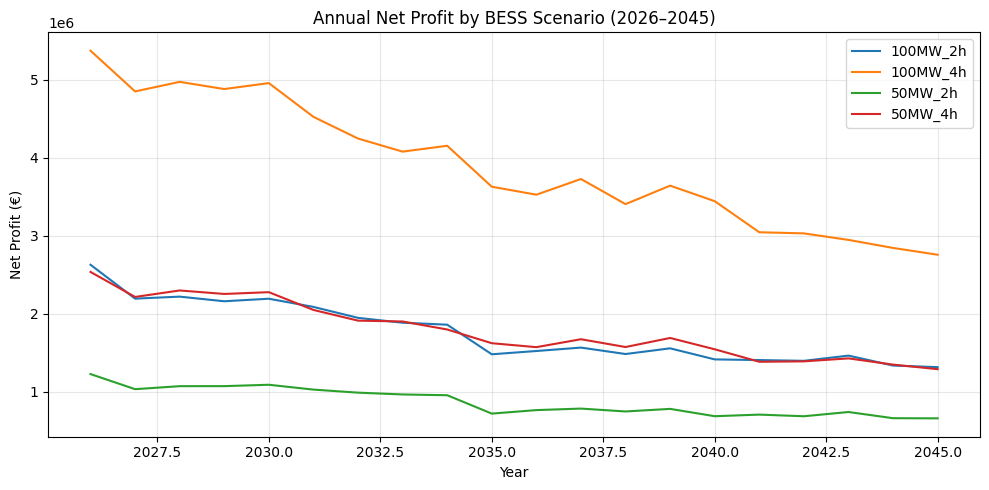

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for scenario_name, grp in all_yearly.groupby("Scenario"):
    plt.plot(grp["Year"], grp["Net_Profit_EUR"], label=scenario_name)

plt.xlabel("Year")
plt.ylabel("Net Profit (€)")
plt.title("Annual Net Profit by BESS Scenario (2026–2045)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Total energy discharged in 2026: 46636.1857325 MWh
Total energy charged in 2026: 51716.549288088645 MWh


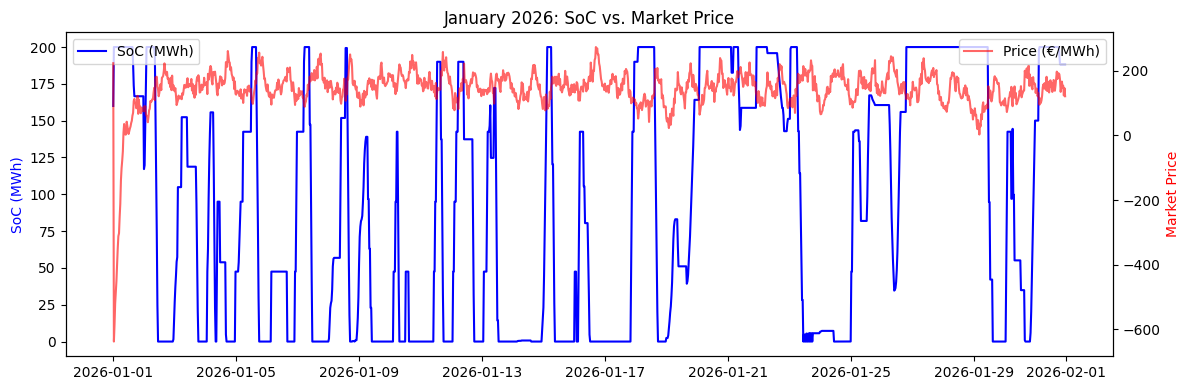

In [181]:
year2026 = df_detailed[df_detailed['Year'] == 2026]

# How many half-hours did we discharge vs. charge in 2026?
print("Total energy discharged in 2026:", year2026['Energy_Discharged_Net_MWh'].sum(), "MWh")
print("Total energy charged in 2026:",    year2026['Energy_Charged_Gross_MWh'].sum(), "MWh")

# Plot 2026 SoC vs. price for, e.g., January 2026:
jan2026 = year2026['2026-01-01':'2026-01-31']
plt.figure(figsize=(12, 4))
ax1 = plt.gca()
ax1.plot(jan2026.index, jan2026['SoC_MWh'], label='SoC (MWh)', color='blue')
ax1.set_ylabel('SoC (MWh)', color='blue')
ax2 = ax1.twinx()
ax2.plot(jan2026.index, jan2026['Market_Price_EUR_per_MWh'], label='Price (€/MWh)', color='red', alpha=0.6)
ax2.set_ylabel('Market Price', color='red')
plt.title('January 2026: SoC vs. Market Price')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [182]:
import pandas as pd

# 1) Read each scenario’s yearly CSV
df_4h_50  = pd.read_csv("bess_50MW_4h_yearly_summary_20yr.csv")
df_2h_50  = pd.read_csv("bess_50MW_2h_yearly_summary_20yr.csv")
df_4h_100 = pd.read_csv("bess_100MW_4h_yearly_summary_20yr.csv")
df_2h_100 = pd.read_csv("bess_100MW_2h_yearly_summary_20yr.csv")

# 2) Tag them with a scenario column
df_4h_50["Scenario"]  = "50MW_4h"
df_2h_50["Scenario"]  = "50MW_2h"
df_4h_100["Scenario"] = "100MW_4h"
df_2h_100["Scenario"] = "100MW_2h"

# 3) Concatenate into one big DataFrame
all_yearly = pd.concat([df_4h_50, df_2h_50, df_4h_100, df_2h_100], ignore_index=True)

# 4) Now you have a single DataFrame with columns like Year, Total_Revenue_EUR, Net_Profit_EUR, etc.,
#    plus a “Scenario” column so you can compare across batteries.
print(all_yearly.head())

   Total_Revenue_EUR  Total_Operational_Cost_EUR  Total_Degradation_Cost_EUR  \
0       8.816165e+06                6.140275e+06               139733.303198   
1       8.136510e+06                5.790453e+06               130955.024467   
2       7.895985e+06                5.469387e+06               128224.540365   
3       7.988377e+06                5.607621e+06               127204.425571   
4       7.923812e+06                5.521777e+06               125617.688477   

   Net_Profit_EUR  Total_Energy_Discharged_Net_MWh  \
0    2.536157e+06                     46577.767732   
1    2.215102e+06                     43651.674822   
2    2.298374e+06                     42741.513455   
3    2.253552e+06                     42401.475190   
4    2.276417e+06                     41872.562826   

   Total_Energy_Charged_Gross_MWh  Missed_Discharge_Ops  Missed_Charge_Ops  \
0                    51651.820202                  3992               4604   
1                    48367.506729     

In [183]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell Z: Push all BESS CSVs into a Google Drive folder
# ────────────────────────────────────────────────────────────────────────────────

from google.colab import drive
import os
import shutil

# 1) Mount your Drive (if you’ve already done this earlier you can skip it)
drive.mount('/content/drive')

# 2) Define the destination folder in your Drive
#    (e.g. "My Drive/BESS_Outputs")
drive_folder = '/content/drive/My Drive/BESS_Outputs'
os.makedirs(drive_folder, exist_ok=True)

# 3) List out all the CSVs in the notebook’s working directory
csv_files = [fn for fn in os.listdir('.') if fn.endswith('.csv') and fn.startswith('bess_')]

print(f"Found {len(csv_files)} CSVs to copy:", csv_files)

# 4) Copy each one into your Drive folder
for fn in csv_files:
    dest = os.path.join(drive_folder, fn)
    shutil.copy(fn, dest)
    print(f"  • {fn} → {dest}")

print("\n✅ All BESS CSVs have been copied to your Google Drive folder.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 17 CSVs to copy: ['bess_100MW_4h_20yr_detailed.csv', 'bess_50MW_2h_yearly_summary_20yr.csv', 'bess_100MW_2h_20yr_detailed.csv', 'bess_50MW_4h_yearly_summary_20yr.csv', 'bess_yearly_summary_50MW_4h.csv', 'bess_50MW_2h_20yr_detailed.csv', 'bess_50MW_4h_20yr_detailed.csv', 'bess_20yr_consolidated_summary.csv', 'bess_yearly_custom_100MW_4h.csv', 'bess_100MW_2h_yearly_summary_20yr.csv', 'bess_yearly_custom_100MW_2h.csv', 'bess_yearly_summary_100MW_4h.csv', 'bess_yearly_custom_50MW_2h.csv', 'bess_yearly_custom_50MW_4h.csv', 'bess_yearly_summary_100MW_2h.csv', 'bess_yearly_summary_50MW_2h.csv', 'bess_100MW_4h_yearly_summary_20yr.csv']
  • bess_100MW_4h_20yr_detailed.csv → /content/drive/My Drive/BESS_Outputs/bess_100MW_4h_20yr_detailed.csv
  • bess_50MW_2h_yearly_summary_20yr.csv → /content/drive/My Drive/BESS_Outputs/bess_50MW_2h_yearly_summary_20yr.csv
  • b